1. Download Dataset using KaggleHub

In [27]:
import kagglehub

# Download latest version from KaggleHub
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")
print("📂 Dataset path:", path)


📂 Dataset path: /kaggle/input/loan-approval-prediction-dataset


2. Load and Inspect Dataset

In [28]:
import pandas as pd

# Load CSV
df = pd.read_csv(f"{path}/loan_approval_dataset.csv")

# Remove leading/trailing spaces in column names
df.columns = df.columns.str.strip()

# Display basic structure
print(df.info())
print("\nMissing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None

Missing values:
 loan_id

3. Explore Categorical Features

In [29]:
# Check unique values in target and categorical features
print("Loan Status values:", df['loan_status'].unique())
print("Education values:", df['education'].unique())
print("Self Employed values:", df['self_employed'].unique())


Loan Status values: [' Approved' ' Rejected']
Education values: [' Graduate' ' Not Graduate']
Self Employed values: [' No' ' Yes']


4. Encode Categorical Features

In [30]:
from sklearn.preprocessing import LabelEncoder

# Drop ID column
df.drop('loan_id', axis=1, inplace=True)

# Encode categorical features
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])        # e.g., Graduate=1, Not Graduate=0
df['self_employed'] = le.fit_transform(df['self_employed'])  # Yes=1, No=0
df['loan_status'] = le.fit_transform(df['loan_status'])    # Approved=1, Rejected=0

# Separate features and label
X = df.drop('loan_status', axis=1)
y = df['loan_status']


5. Train-Test Split and Scaling

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


6. Train Classification Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Use class_weight='balanced' to handle imbalance
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

7. Evaluate Model Performance

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

🧾 Confusion Matrix:
[[528   3]
 [ 13 310]]


8. Visualize Feature Importances

/tmp/ipython-input-429799077.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


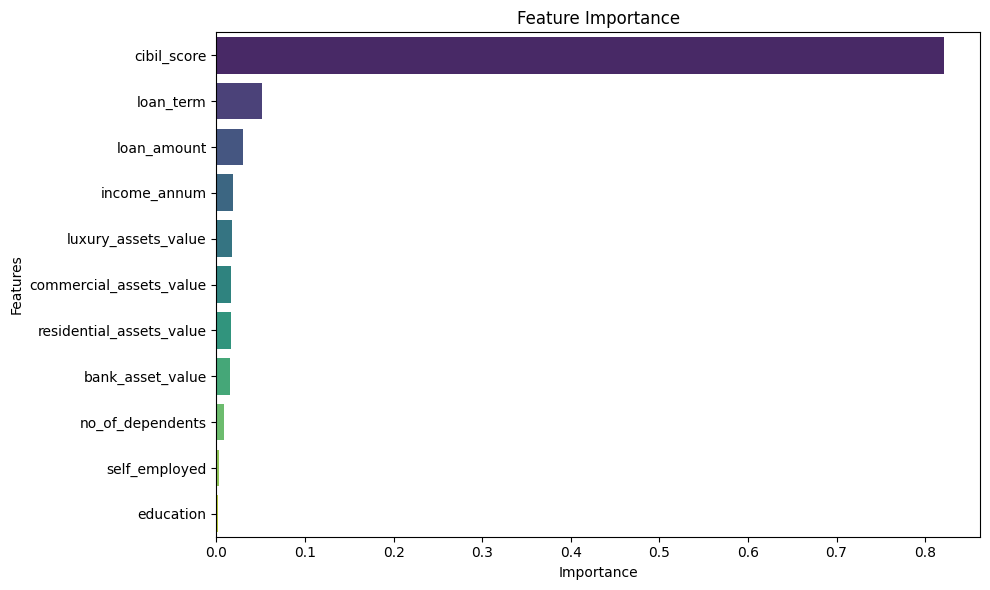

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


9. Streamlit Web App (loan_approval_app.py)

In [50]:
%%writefile loan_approval_app.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Title and description
st.set_page_config(page_title="Loan Approval Prediction", page_icon="🏦")
st.title("🏦 Loan Approval Prediction App")
st.markdown("Predict whether a loan application will be approved based on applicant details.")

# Load dataset
@st.cache_data
def load_data():
    df = pd.read_csv("/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv")
    df.columns = df.columns.str.strip()
    return df

df = load_data()

# Show raw dataset
with st.expander("📂 View Raw Dataset"):
    st.dataframe(df.head())

# Preprocessing
df_clean = df.copy()
df_clean.drop('loan_id', axis=1, inplace=True)

# Label Encoding
le_edu = LabelEncoder()
le_emp = LabelEncoder()
le_status = LabelEncoder()

df_clean['education'] = le_edu.fit_transform(df_clean['education'])
df_clean['self_employed'] = le_emp.fit_transform(df_clean['self_employed'])
df_clean['loan_status'] = le_status.fit_transform(df_clean['loan_status'])

# Features and target
X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# ---------------- User Form Input ----------------
st.header("📥 Enter Applicant Information")

with st.form("loan_form"):
    no_of_dependents = st.number_input("No. of Dependents", min_value=0, step=1)
    education = st.selectbox("Education", ['Graduate', 'Not Graduate'])
    self_employed = st.selectbox("Self Employed", ['Yes', 'No'])
    income_annum = st.number_input("Annual Income", min_value=0)
    loan_amount = st.number_input("Loan Amount", min_value=0)
    loan_term = st.number_input("Loan Term (months)", min_value=0)
    cibil_score = st.number_input("CIBIL Score (300–900)", min_value=300, max_value=900)
    residential_assets_value = st.number_input("Residential Asset Value", min_value=0)
    commercial_assets_value = st.number_input("Commercial Asset Value", min_value=0)
    luxury_assets_value = st.number_input("Luxury Asset Value", min_value=0)
    bank_asset_value = st.number_input("Bank Asset Value", min_value=0)

    submit = st.form_submit_button("Predict Loan Approval")

# ---------------- Prediction Logic ----------------
if submit:
    # Manual encoding
    edu_val = 1 if education == "Graduate" else 0
    emp_val = 1 if self_employed == "Yes" else 0

    input_data = np.array([[no_of_dependents, edu_val, emp_val, income_annum, loan_amount,
                            loan_term, cibil_score, residential_assets_value,
                            commercial_assets_value, luxury_assets_value, bank_asset_value]])

    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)[0]

    result = "✅ Loan Approved!" if prediction == 1 else "❌ Loan Rejected."
    st.subheader("📊 Prediction Result:")
    st.success(result)

# ---------------- Evaluation ----------------
with st.expander("📈 Model Evaluation"):
    y_pred = model.predict(X_test_scaled)
    st.text("Classification Report:")
    st.text(classification_report(y_test, y_pred))
    st.text("Confusion Matrix:")
    st.text(confusion_matrix(y_test, y_pred))


Overwriting loan_approval_app.py


10. Set up Ngrok Auth Token

In [51]:
from pyngrok import ngrok
ngrok.set_auth_token("YOUR_TOKEN_HERE")

11. Launch Streamlit App via Ngrok Tunnel

In [53]:
# Run Streamlit app silently in background
!streamlit run loan_approval_app.py &> /dev/null &

# Wait for server to start
import time
time.sleep(5)

# Open tunnel on port 8501
public_url = ngrok.connect(8501)
print("🌐 Your Streamlit app is live at:", public_url)


🌐 Your Streamlit app is live at: NgrokTunnel: "https://b2e86ff0c7c2.ngrok-free.app" -> "http://localhost:8501"
